# Probabilistic Weighted FTS

Silva, P. C. L; Guimarães, F. G.; Sadaei, H. J. Probabilistic Forecasting With Fuzzy Time Series. Under publishing.


## Environment Setup

### Library install/update

In [ ]:
!pip3 install -U git+https://github.com/petroniocandido/pyFTS
!pip3 install -U git+https://github.com/nicolaskruchten/jupyter_pivottablejs.git
!git clone https://github.com/petroniocandido/stac
!curl -O https://github.com/petroniocandido/PWFTS/blob/master/benchmarks.db.gz
!gunzip benchmarks.db.gz

In [4]:
!gunzip benchmarks.db.gz

gzip: benchmarks.db.gz: No such file or directory


### External libraries import

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib notebook

In [6]:
import ipympl
import matplotlib.pyplot as plt
import seaborn as sns

### Common pyFTS imports and defaults

In [7]:
from pyFTS.common import Util as cUtil
from pyFTS.benchmarks import benchmarks as bchmk, Util as bUtil

from pyFTS.models import pwfts

from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

## Datasets

### Data Loading

In [8]:
from pyFTS.data import TAIEX, NASDAQ, SP500

dataset_names = ["TAIEX", "SP500","NASDAQ"]

def get_dataset(name):
    if dataset_name == "TAIEX":
        return TAIEX.get_data()
    elif dataset_name == "SP500":
        return SP500.get_data()[11500:16000]
    elif dataset_name == "NASDAQ":
        return NASDAQ.get_data()


train_split = 2000
test_length = 200


### Plots

<IPython.core.display.Javascript object>


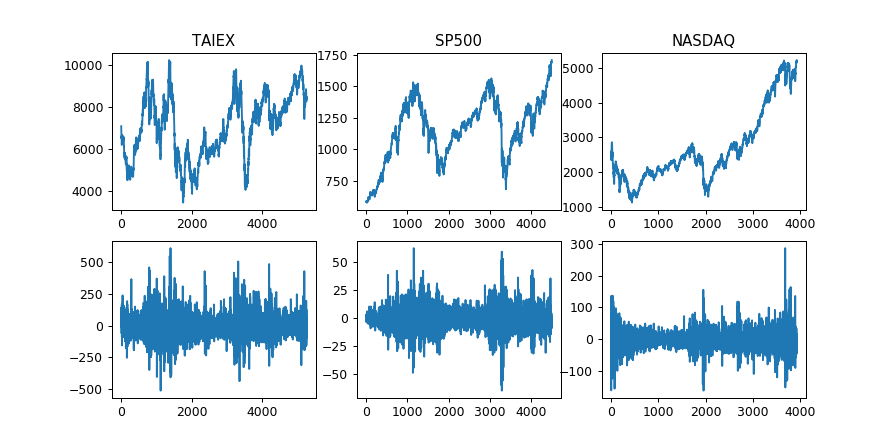

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[10,5])

for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)
    dataset_diff = tdiff.apply(dataset)

    ax[0][count].plot(dataset)
    ax[1][count].plot(dataset_diff)
    ax[0][count].set_title(dataset_name)

#cUtil.show_and_save_image(fig,"taiex",False)

### Statistics

In [10]:
rows =[]

for count,dataset_name in enumerate(dataset_names):
    row = [dataset_name]
    dataset = get_dataset(dataset_name)
    result = adfuller(dataset)
    row.extend([result[0],result[1]])
    row.extend([value for key, value in result[4].items()])
    rows.append(row)
    
pd.DataFrame(rows,columns=['Dataset','ADF Statistic','p-value','Cr. Val. 1%','Cr. Val. 5%','Cr. Val. 10%'])


,Dataset,ADF Statistic,p-value,Cr. Val. 1%,Cr. Val. 5%,Cr. Val. 10%
0,TAIEX,-2.656728,0.081830,-3.431601,-2.862093,-2.567064
1,SP500,-1.747171,0.406987,-3.431811,-2.862186,-2.567114
2,NASDAQ,0.476224,0.984132,-3.432022,-2.862279,-2.567163


## Partitioning

### Common imports

In [5]:
from pyFTS.partitioners import Grid, Util as pUtil


### Partitioning exploring and optimization

**CAUTION**: This task is computationally expensive and take several hours to be performed. We strongly recommend to use the distributed version with a dispy cluster.

In [ ]:
from pyFTS.common import Transformations
from pyFTS.data import TAIEX, SP500, NASDAQ
from pyFTS.benchmarks import benchmarks as bchmk, Util as bUtil

tdiff = Transformations.Differential(1)

_type = 'point'
tag = "partitioning"

for dataset_name in dataset_names:
    dataset = get_dataset(dataset_name)

    bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                    methods=[pwfts.ProbabilisticWeightedFTS],
                                    benchmark_models=False,
                                    transformations=[None],
                                    orders=[1,2,3],
                                    partitions=np.arange(10,100,2), 
                                    progress=False, type=_type,
                                    steps_ahead=[1],
                                    #distributed=True, nodes=['192.168.0.110', '192.168.0.107','192.168.0.106'],
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)

    bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                    methods=[pwfts.ProbabilisticWeightedFTS],
                                    benchmark_models=False,
                                    transformations=[tdiff],
                                    orders=[1,2,3],
                                    partitions=np.arange(3,30,1), 
                                    progress=False, type=_type,
                                    steps_ahead=[1],
                                    #distributed=True, nodes=['192.168.0.110', '192.168.0.107', '192.168.0.106'],
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)

In [12]:
df = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'partitioning' and measure = 'rmse'")

from pivottablejs import pivot_ui


pivot_ui(df,  rows=['Order','Type','Measure'], cols=['Partitions'], vals=['Value'])

<IPython.core.display.Javascript object>


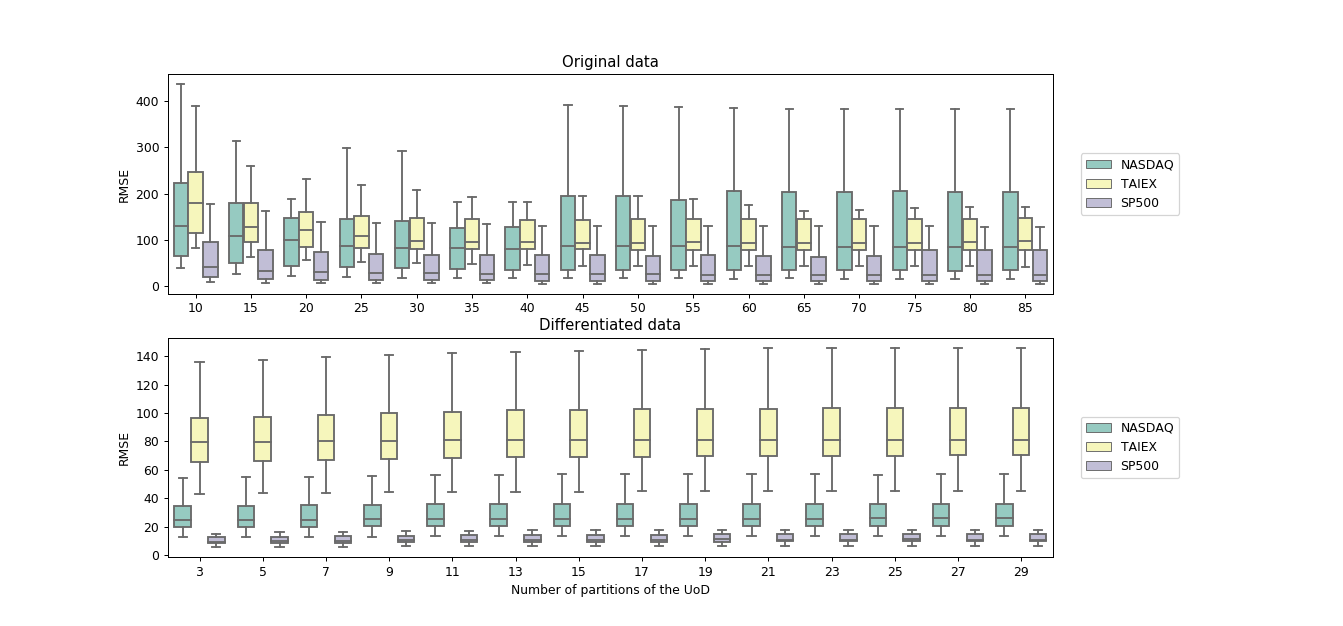

Text(0.5,0,'Number of partitions of the UoD')

In [82]:
df1 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'partitioning' and measure = 'rmse' and benchmarks.'order' = 1 " +
                                  "and transformation is null")

df2 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'partitioning' and measure = 'rmse' and benchmarks.'order' = 1 " +
                                  "and transformation is not null")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,7])

g1 = sns.boxplot(x='Partitions', y='Value', hue='Dataset', data=df1, showfliers=False, ax=ax[0], 
                 palette="Set3")
box = g1.get_position()
g1.set_position([box.x0, box.y0, box.width * 0.85, box.height]) 
g1.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1)
ax[0].set_title("Original data")
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("")

g2 = sns.boxplot(x='Partitions', y='Value', hue='Dataset', data=df2, showfliers=False, ax=ax[1], 
                 palette="Set3")
box = g2.get_position()
g2.set_position([box.x0, box.y0, box.width * 0.85, box.height]) 
g2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1)
ax[1].set_title("Differentiated data")
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Number of partitions of the UoD")


<IPython.core.display.Javascript object>


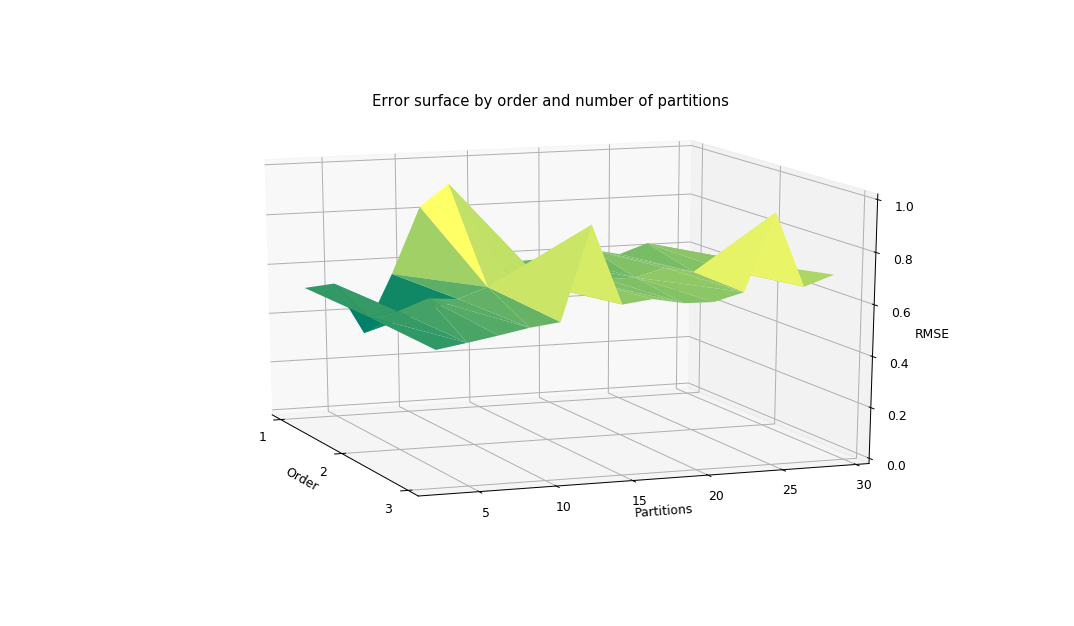

In [13]:
dat = bUtil.get_dataframe_from_bd("benchmarks.db","tag = 'partitioning' " 
                                  +" and dataset = 'TAIEX' and transformation is not null")

from pyFTS.benchmarks import Util as bUtil
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()


df = dat[(dat.Measure == 'rmse') & (dat.Value <= 300)]

df['Value'] = min_max_scaler.fit_transform(df['Value'].reshape(-1, 1))

fig = plt.figure(figsize=[12,7])
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Order'], df['Partitions'], df['Value'], cmap="summer", linewidth=0.2, antialiased=True)
ax.set_title("Error surface by order and number of partitions")
ax.set_xlabel("Order")
ax.set_xticks([1,2,3])
ax.set_ylabel("Partitions")
ax.set_zlabel("RMSE")
ax.set_zlim([0,1])
plt.show()


### Default partitioners

In [7]:
partitioner = Grid.GridPartitioner(data=dataset[:train_split], npart=50)
partitioner_diff = Grid.GridPartitioner(data=dataset[:train_split], npart=5, transformation=tdiff)

### Plots

<IPython.core.display.Javascript object>


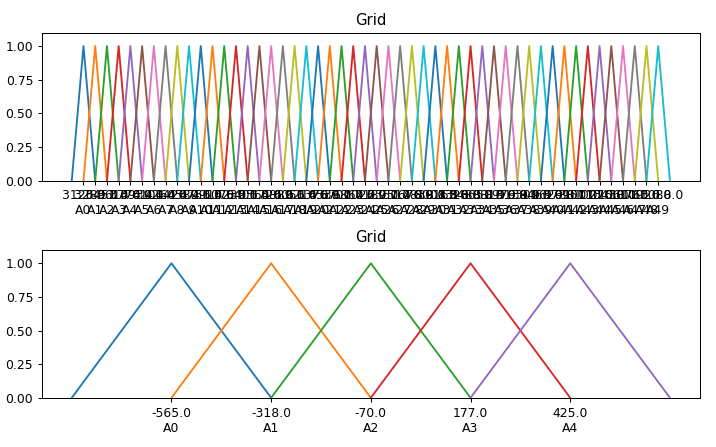

In [96]:

pUtil.plot_partitioners(dataset[:train_split], [partitioner,partitioner_diff], tam=[8,5])

## Model Training

### Without transformations 

In [8]:
from pyFTS.common import fts,tree
from pyFTS.models import hofts, pwfts

pfts1_taiex = pwfts.ProbabilisticWeightedFTS(partitioner=partitioner)
pfts1_taiex.fit(dataset[:train_split], save_model=True, file_path='pwfts', order=1)
pfts1_taiex.shortname = "1st Order"
print(pfts1_taiex)

Probabilistic FTS:
(0.039) A10 -> (0.597)A10, (0.245)A11, (0.006)A12, (0.0)A13, (0.0)A7, (0.007)A8, (0.145)A9
(0.041) A11 -> (0.233)A10, (0.491)A11, (0.233)A12, (0.031)A13, (0.011)A9
(0.047) A12 -> (0.012)A10, (0.209)A11, (0.591)A12, (0.169)A13, (0.018)A14
(0.031) A13 -> (0.007)A10, (0.03)A11, (0.28)A12, (0.468)A13, (0.176)A14, (0.036)A15, (0.003)A16
(0.028) A14 -> (0.003)A11, (0.016)A12, (0.231)A13, (0.484)A14, (0.235)A15, (0.029)A16, (0.002)A17
(0.039) A15 -> (0.004)A12, (0.022)A13, (0.189)A14, (0.513)A15, (0.243)A16, (0.029)A17, (0.0)A18
(0.041) A16 -> (0.019)A14, (0.233)A15, (0.488)A16, (0.229)A17, (0.02)A18, (0.008)A19, (0.003)A20
(0.034) A17 -> (0.003)A14, (0.045)A15, (0.288)A16, (0.428)A17, (0.22)A18, (0.016)A19, (0.0)A20
(0.037) A18 -> (0.001)A15, (0.023)A16, (0.228)A17, (0.508)A18, (0.234)A19, (0.007)A20
(0.035) A19 -> (0.001)A16, (0.015)A17, (0.263)A18, (0.498)A19, (0.21)A20, (0.013)A21, (0.001)A22, (0.001)A23
(0.002) A2 -> (0.387)A2, (0.569)A3, (0.044)A4
(0.042) A20 -> (0.0)

<IPython.core.display.Javascript object>


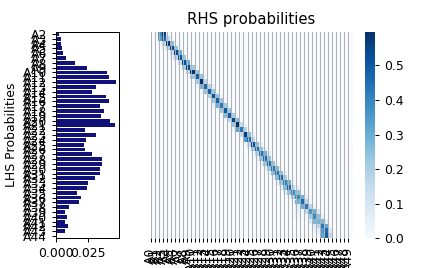

In [98]:
pwfts.visualize_distributions(pfts1_taiex, size=(5,3))

### With transformations 

In [27]:
from pyFTS.models import pwfts

pfts1_taiex_diff = pwfts.ProbabilisticWeightedFTS(partitioner=partitioner_diff)
pfts1_taiex_diff.append_transformation(tdiff)
pfts1_taiex_diff.fit(dataset[:train_split], order=2, save_model=True, file_path='pwfts_diff')
pfts1_taiex_diff.shortname = "Diff"
print(pfts1_taiex_diff)

Probabilistic FTS:
(0.0) A0,A0 -> (0.104)A1, (0.766)A2, (0.131)A3
(0.0) A0,A1 -> (0.076)A1, (0.743)A2, (0.181)A3
(0.001) A0,A2 -> (0.017)A1, (0.54)A2, (0.414)A3, (0.029)A4
(0.0) A0,A3 -> (0.026)A1, (0.246)A2, (0.625)A3, (0.103)A4
(0.0) A1,A0 -> (0.027)A0, (0.621)A1, (0.284)A2, (0.069)A3
(0.006) A1,A1 -> (0.001)A0, (0.157)A1, (0.682)A2, (0.159)A3
(0.032) A1,A2 -> (0.077)A1, (0.642)A2, (0.275)A3, (0.006)A4
(0.01) A1,A3 -> (0.103)A1, (0.57)A2, (0.317)A3, (0.009)A4
(0.0) A1,A4 -> (0.173)A1, (0.496)A2, (0.331)A3
(0.001) A2,A0 -> (0.005)A0, (0.173)A1, (0.756)A2, (0.067)A3
(0.028) A2,A1 -> (0.001)A0, (0.126)A1, (0.687)A2, (0.185)A3, (0.002)A4
(0.402) A2,A2 -> (0.001)A0, (0.041)A1, (0.656)A2, (0.296)A3, (0.007)A4
(0.188) A2,A3 -> (0.001)A0, (0.033)A1, (0.594)A2, (0.361)A3, (0.011)A4
(0.005) A2,A4 -> (0.004)A0, (0.119)A1, (0.472)A2, (0.367)A3, (0.039)A4
(0.0) A3,A0 -> (0.004)A0, (0.18)A1, (0.713)A2, (0.104)A3
(0.012) A3,A1 -> (0.004)A0, (0.096)A1, (0.635)A2, (0.252)A3, (0.014)A4
(0.184) A3,A2 -

<IPython.core.display.Javascript object>


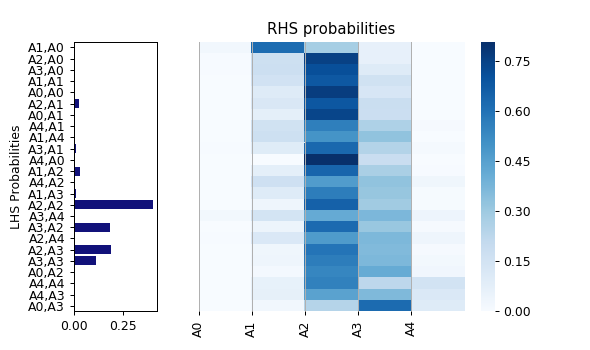

In [31]:
pwfts.visualize_distributions(pfts1_taiex_diff, size=(5,3))

## Test Forecasting

### Probabilistic forecasting one step ahead

<IPython.core.display.Javascript object>


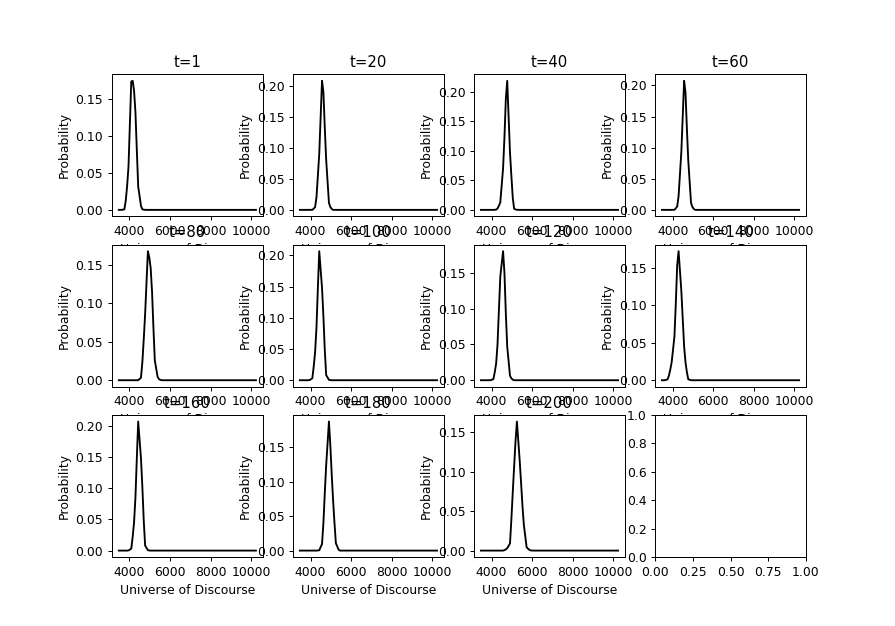

In [99]:
pfts1_taiex = cUtil.load_obj('pwfts')
tmp = pfts1_taiex.predict(dataset[train_split:train_split+200], type='distribution')
f, ax = plt.subplots(3, 4, figsize=[10,7])
tmp[0].plot(ax[0][0], title='t=1')
tmp[20].plot(ax[0][1], title='t=20')
tmp[40].plot(ax[0][2], title='t=40')
tmp[60].plot(ax[0][3], title='t=60')
tmp[80].plot(ax[1][0], title='t=80')
tmp[100].plot(ax[1][1], title='t=100')
tmp[120].plot(ax[1][2], title='t=120')
tmp[140].plot(ax[1][3], title='t=140')
tmp[160].plot(ax[2][0], title='t=160')
tmp[180].plot(ax[2][1], title='t=180')
tmp[199].plot(ax[2][2], title='t=200')

<IPython.core.display.Javascript object>


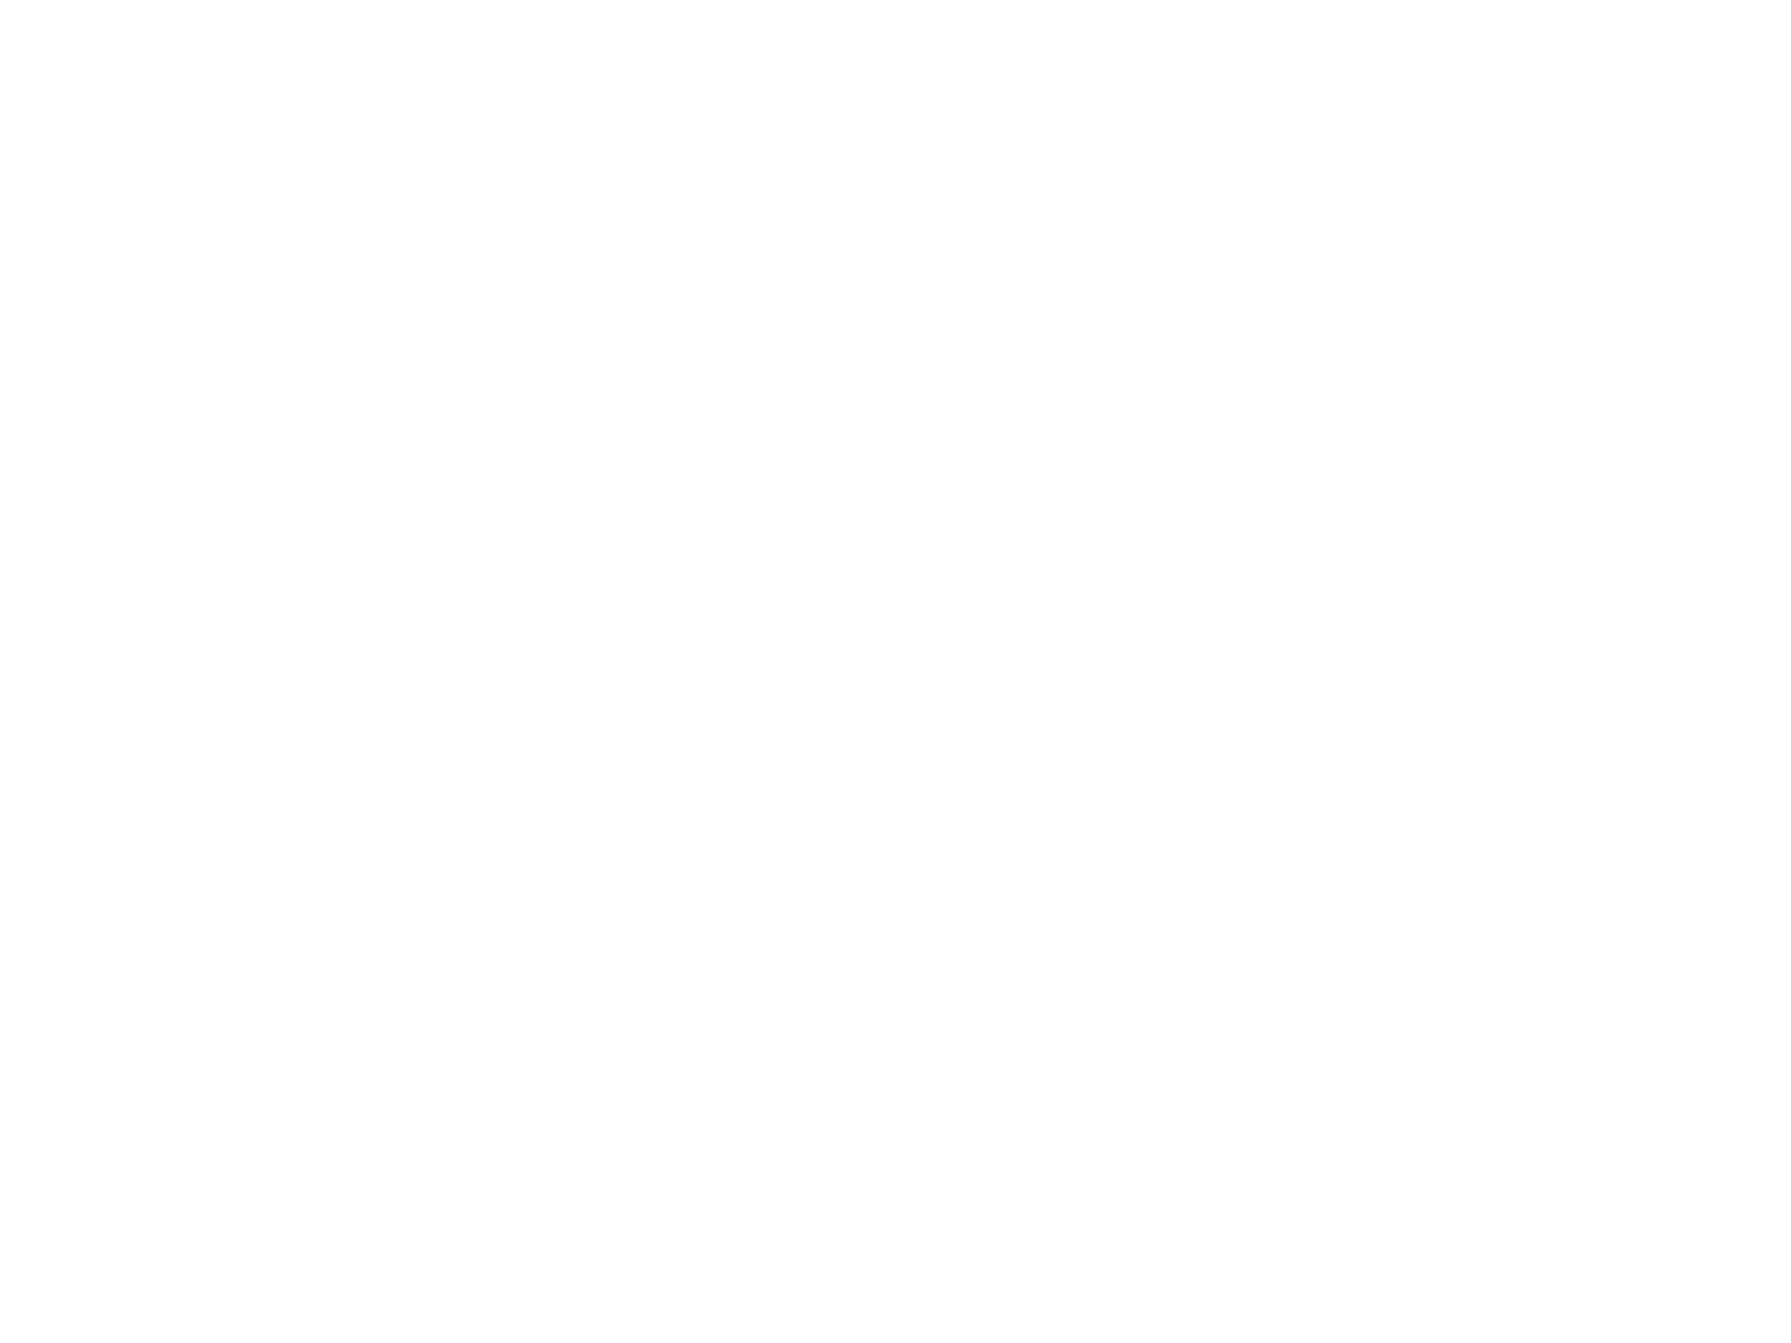

IndexError: list index out of range

In [93]:
pfts1_taiex_diff = Util.load_obj('pwfts_diff')
tmp = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='distribution')
f, ax = plt.subplots(3, 4, figsize=[20,15])
tmp[0].plot(ax[0][0], title='t=1')
tmp[20].plot(ax[0][1], title='t=20')
tmp[40].plot(ax[0][2], title='t=40')
tmp[60].plot(ax[0][3], title='t=60')
tmp[80].plot(ax[1][0], title='t=80')
tmp[100].plot(ax[1][1], title='t=100')
tmp[120].plot(ax[1][2], title='t=120')
tmp[140].plot(ax[1][3], title='t=140')
tmp[160].plot(ax[2][0], title='t=160')
tmp[180].plot(ax[2][1], title='t=180')
tmp[199].plot(ax[2][2], title='t=200')

### Probabilistic forecasting multiple steps ahead

<IPython.core.display.Javascript object>


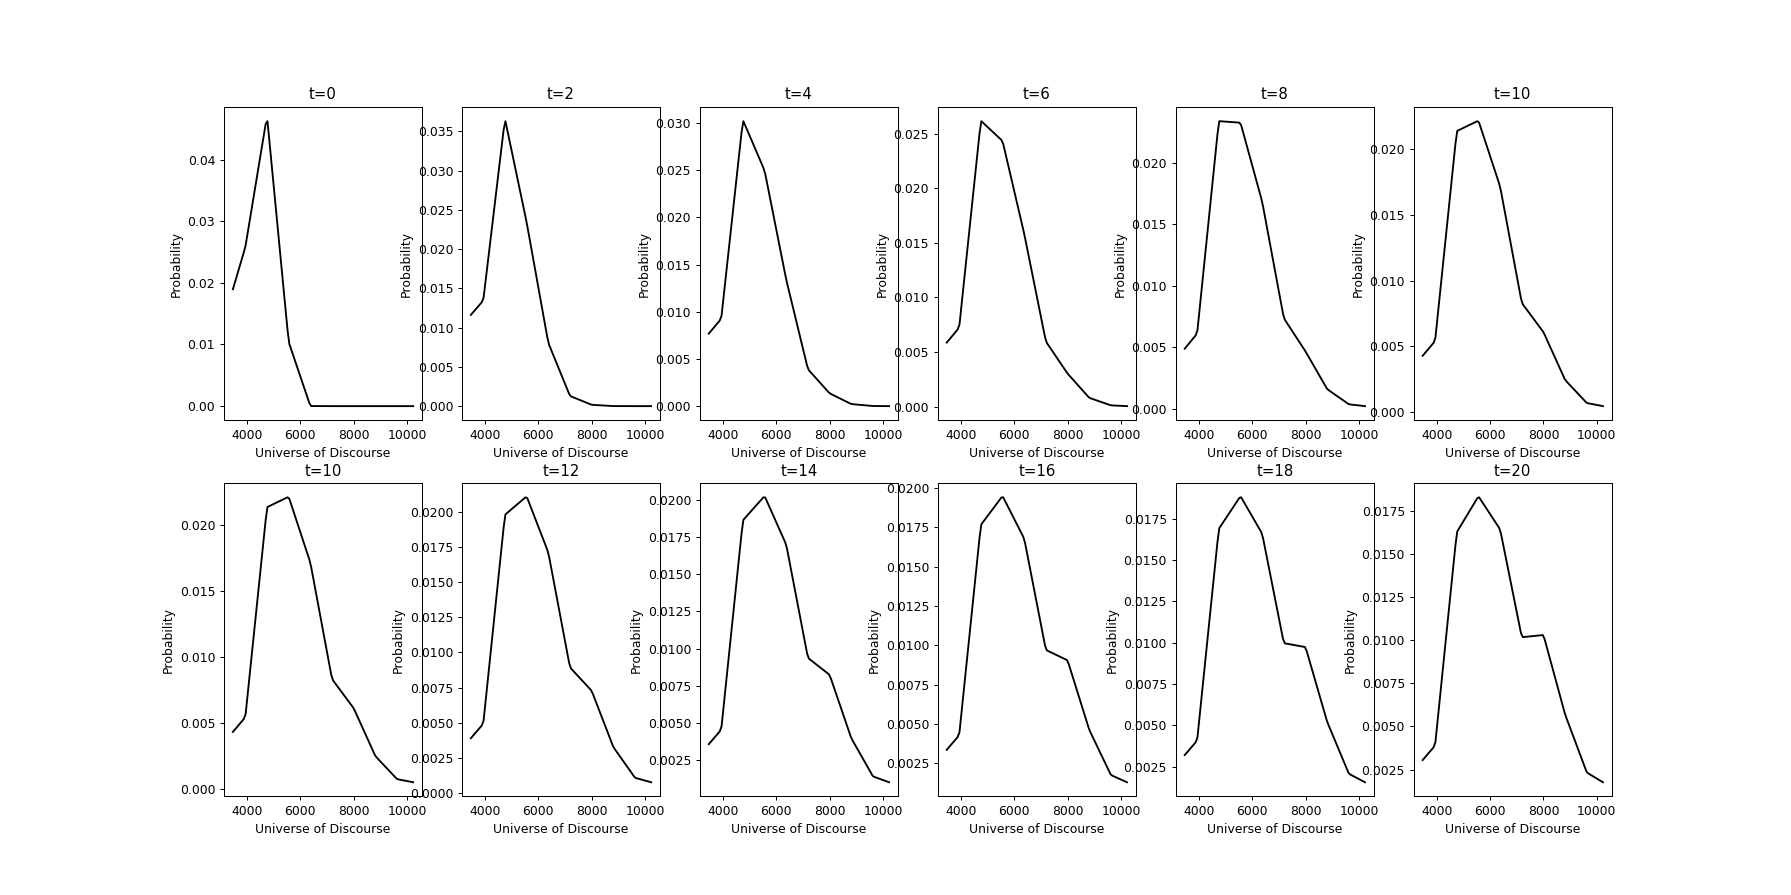

In [91]:
pfts1_taiex = cUtil.load_obj('pwfts')
tmp = pfts1_taiex.predict(dataset[train_split:train_split+200], type='distribution', steps_ahead=20)
f, ax = plt.subplots(2, 6, figsize=[20,10])
tmp[0].plot(ax[0][0], title='t=0')
tmp[2].plot(ax[0][1], title='t=2')
tmp[4].plot(ax[0][2], title='t=4')
tmp[6].plot(ax[0][3], title='t=6')
tmp[8].plot(ax[0][4], title='t=8')
tmp[10].plot(ax[0][5], title='t=10')
tmp[10].plot(ax[1][0], title='t=10')
tmp[12].plot(ax[1][1], title='t=12')
tmp[14].plot(ax[1][2], title='t=14')
tmp[16].plot(ax[1][3], title='t=16')
tmp[18].plot(ax[1][4], title='t=18')
tmp[20].plot(ax[1][5], title='t=20')

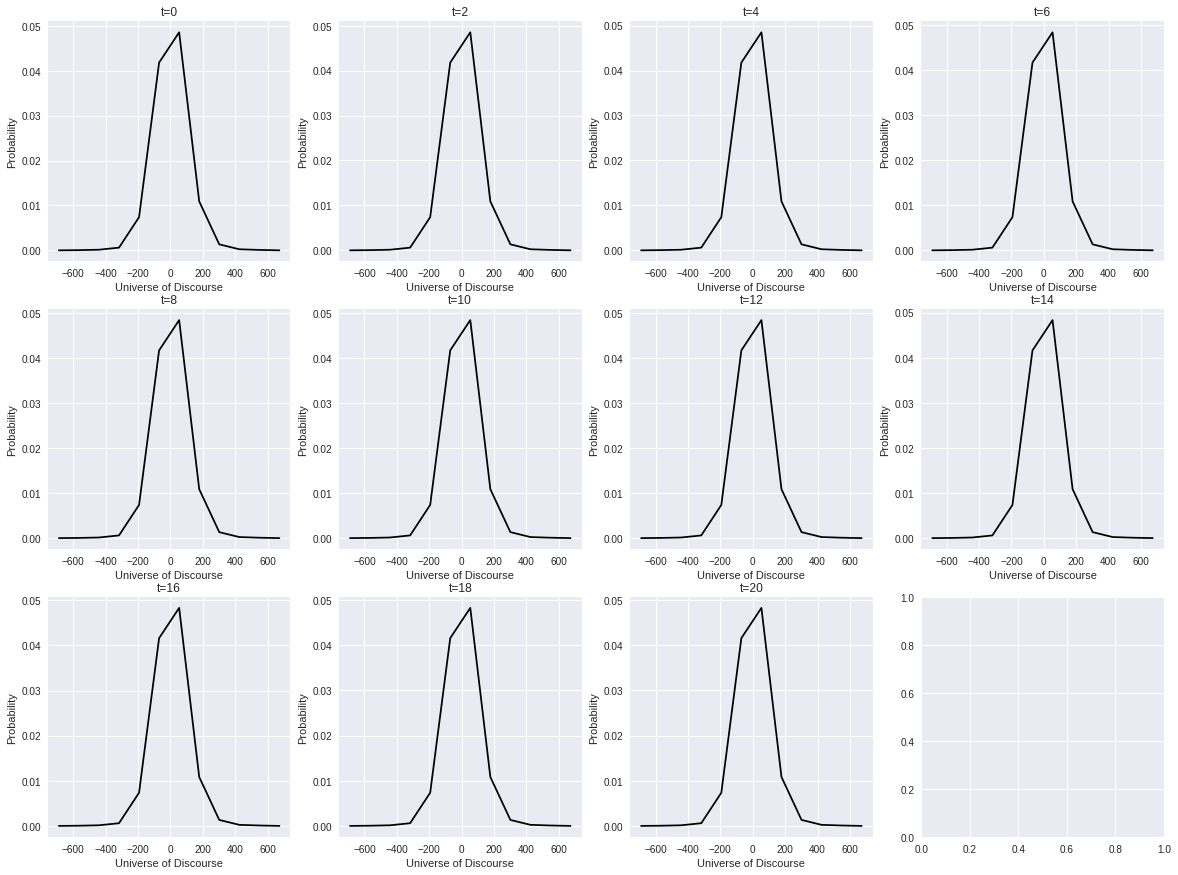

In [46]:
#pfts1_taiex = cUtil.load_obj('pwfts')
tmp = pfts1_taiex_diff.predict(dataset[train_split:train_split+200], type='distribution', steps_ahead=20)
f, ax = plt.subplots(3, 4, figsize=[20,15])
tmp[0].plot(ax[0][0], title='t=0')
tmp[2].plot(ax[0][1], title='t=2')
tmp[4].plot(ax[0][2], title='t=4')
tmp[6].plot(ax[0][3], title='t=6')
tmp[8].plot(ax[1][0], title='t=8')
tmp[10].plot(ax[1][1], title='t=10')
tmp[12].plot(ax[1][2], title='t=12')
tmp[14].plot(ax[1][3], title='t=14')
tmp[16].plot(ax[2][0], title='t=16')
tmp[18].plot(ax[2][1], title='t=18')
tmp[20].plot(ax[2][2], title='t=20')

### All forecasting types, one step ahead

In [ ]:
distributions = pfts1_taiex.predict(dataset[train_split:train_split+200], type='distribution')
intervals = pfts1_taiex.predict(dataset[train_split:train_split+200], type='interval', method='heuristic')
points = pfts1_taiex.predict(dataset[train_split:train_split+200], type='point', method='heuristic')

qtle1 = []
qtle2 = []
expected = []
for dist in distributions:
    tmp = dist.quantile([.05, .25, .5, .75 ,.95])
    qtle1.append([tmp[0], tmp[4]])
    qtle2.append([tmp[1], tmp[3]])
    expected.append(dist.expected_value())


<IPython.core.display.Javascript object>


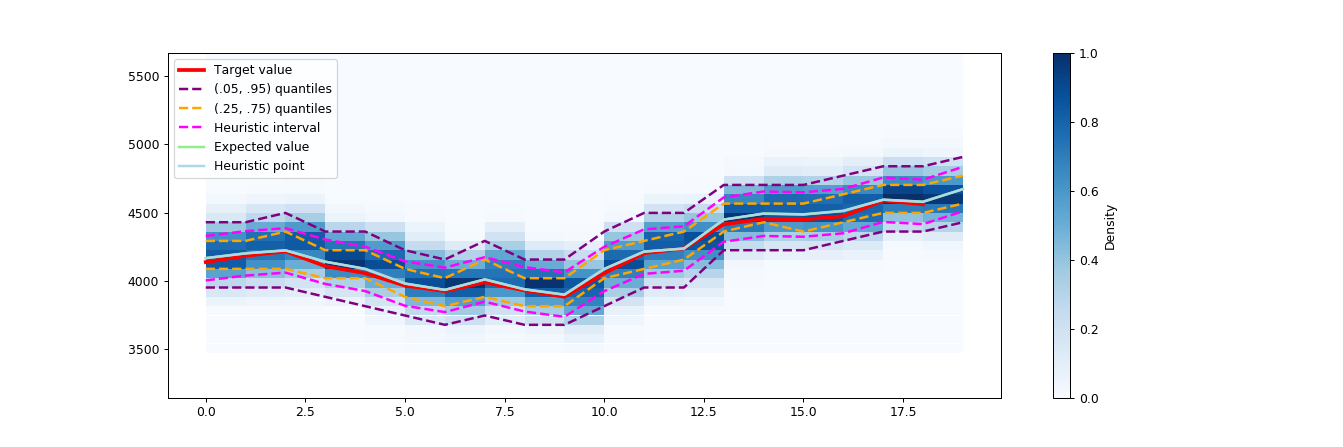

In [134]:
from pyFTS.benchmarks import benchmarks as bchmk

length=20

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,length-1), dataset[train_split:train_split+length-1], 
        color="red", lw=3, label='Target value')

bchmk.plot_distribution(ax, "Blues", distributions[:length-1], f, 0)

mi, ma = bchmk.plot_interval(ax, qtle1[:length], 0, color='purple', 
                             label="(.05, .95) quantiles", ls='--', linewidth=2)
bchmk.plot_interval(ax, qtle2[:length], 0, color='orange', 
                    label="(.25, .75) quantiles", ls='--', linewidth=2)
bchmk.plot_interval(ax, intervals[:length], 0, color='magenta', 
                    label="Heuristic interval", ls='--', linewidth=2)

ax.plot(np.arange(0,length), expected[:length], color="lightgreen", label='Expected value', linewidth=2)
ax.plot(np.arange(0,length), points[:length], color="lightblue", label='Heuristic point', linewidth=2)

ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

### All forecasting types, multiple step ahead

In [8]:
pfts1_taiex = cUtil.load_obj('pwfts')

steps = 20

distributions = pfts1_taiex.predict(dataset[train_split:train_split+200], type='distribution', steps_ahead=steps)
intervals = pfts1_taiex.predict(dataset[train_split:train_split+200], type='interval', method='heuristic', steps_ahead=steps)
points = pfts1_taiex.predict(dataset[train_split:train_split+200], type='point', method='heuristic', steps_ahead=steps)

qtle1 = []
qtle2 = []
expected = []
for dist in distributions:
    tmp = dist.quantile([.05, .25, .5, .75 ,.95])
    qtle1.append([tmp[0], tmp[4]])
    qtle2.append([tmp[1], tmp[3]])
    expected.append(dist.expected_value())


<IPython.core.display.Javascript object>


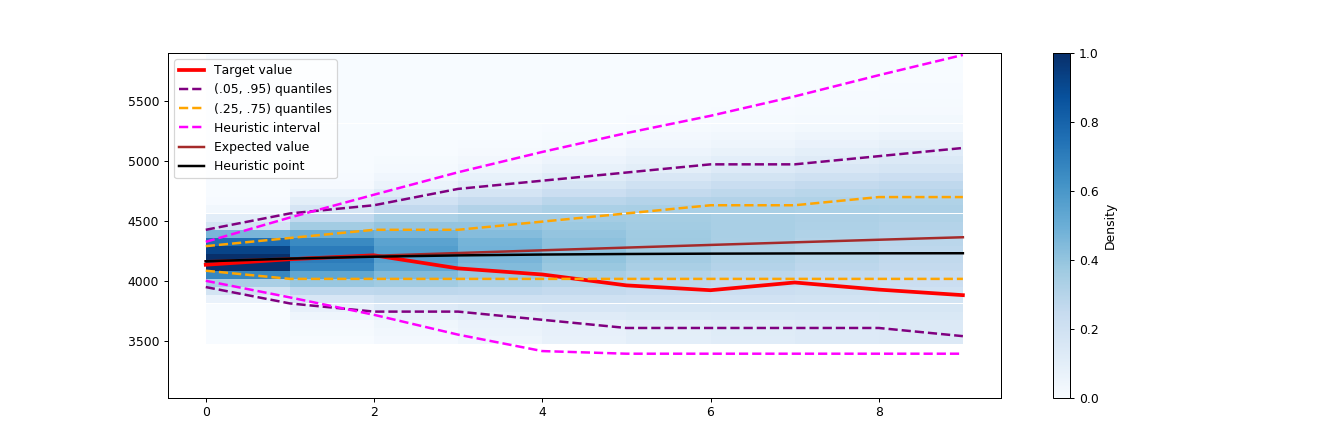

In [13]:
from pyFTS.benchmarks import benchmarks as bchmk

length=10

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,length), dataset[train_split:train_split+length], 
        color="red", lw=3, label='Target value')

bchmk.plot_distribution(ax, "Blues", distributions[:length-1], f, 0)

mi, ma = bchmk.plot_interval(ax, qtle1[:length], 0, color='purple', 
                             label="(.05, .95) quantiles", ls='--', linewidth=2)
bchmk.plot_interval(ax, qtle2[:length], 0, color='orange', 
                    label="(.25, .75) quantiles", ls='--', linewidth=2)
bchmk.plot_interval(ax, intervals[:length], 0, color='magenta', 
                    label="Heuristic interval", ls='--', linewidth=2)

ax.plot(np.arange(0,length), expected[:length], color="brown", label='Expected value', linewidth=2)
ax.plot(np.arange(0,length), points[:length], color="black", label='Heuristic point', linewidth=2)

ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

## Computational Experiments

### Multiple steps ahead

**CAUTION**: This task is computationally expensive and take several hours to be performed. We strongly recommend to use the distributed version with a dispy cluster.

In [ ]:
from pyFTS.common import Transformations
from pyFTS.data import TAIEX, SP500, NASDAQ
from pyFTS.benchmarks import benchmarks as bchmk, Util as bUtil

tdiff = Transformations.Differential(1)

types = ['point','interval','distribution']
tag = "ahead2"

for dataset_name in dataset_names:
    dataset = get_dataset(dataset_name)

    for ct, _type in enumerate(types):
        bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                        methods=[pwfts.ProbabilisticWeightedFTS],
                                        benchmark_models=False,
                                        transformations=[None],
                                        orders=[1],
                                        partitions=[30], 
                                        progress=False, type=_type,
                                        steps_ahead=[2, 4, 6, 8, 10],
                                        #distributed=True, nodes=['192.168.0.110', '192.168.0.107','192.168.0.106'],
                                        file="benchmarks.db", dataset=dataset_name, tag=tag)

        bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                        methods=[pwfts.ProbabilisticWeightedFTS],
                                        benchmark_models=False,
                                        transformations=[tdiff],
                                        orders=[1],
                                        partitions=[5], 
                                        progress=False, type=_type,
                                        steps_ahead=[2, 4, 6, 8, 10],
                                        #distributed=True, nodes=['192.168.0.110', '192.168.0.107', '192.168.0.106'],
                                        file="benchmarks.db", dataset=dataset_name, tag=tag)

<IPython.core.display.Javascript object>


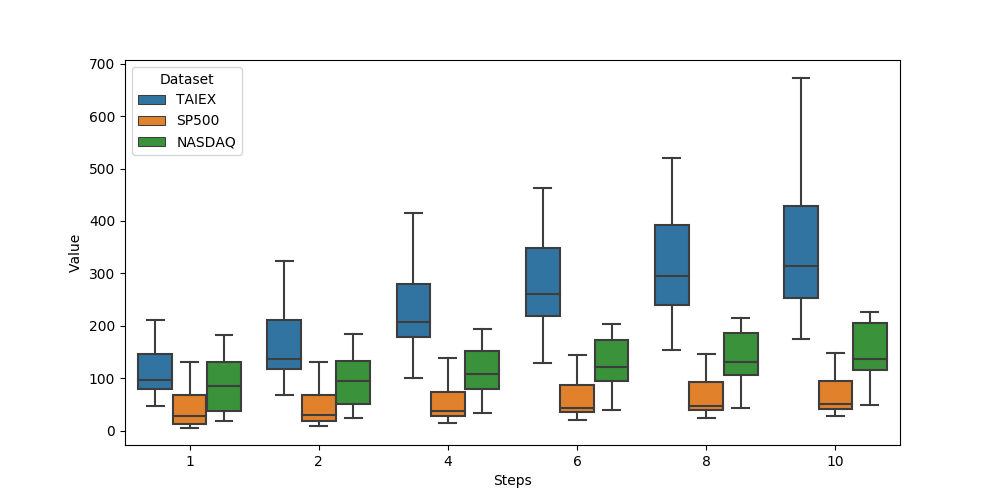

In [11]:
df = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'ahead' and measure = 'rmse' and transformation is null")

fig = plt.figure(figsize=[10,5])
sns.boxplot(x='Steps', y='Value', hue='Dataset',  data=df, showfliers=False)

<IPython.core.display.Javascript object>


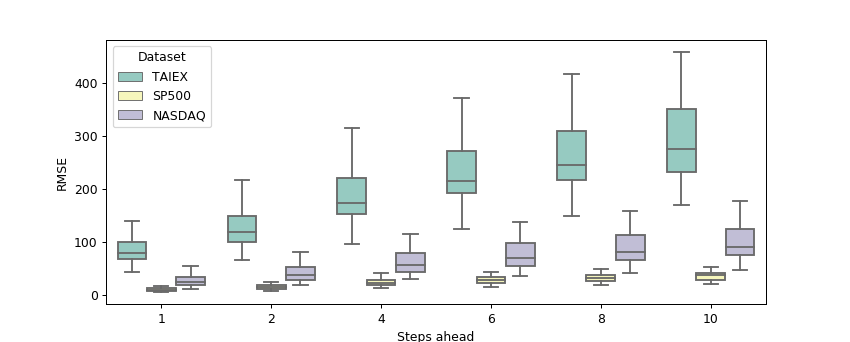

Text(0,0.5,'RMSE')

In [142]:
df = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'ahead' and measure = 'rmse' and transformation is not null")

fig = plt.figure(figsize=[8,4])
g = sns.boxplot(x='Steps', y='Value', hue='Dataset',  data=df, showfliers=False,palette="Set3")
g.set_xlabel("Steps ahead")
g.set_ylabel("RMSE")

### Method comparisons

#### Running the experiments

**CAUTION**: This task is computationally expensive and take several hours to be performed. We strongly recommend to use the distributed version with a dispy cluster.

In [ ]:
from pyFTS.common import Transformations
from pyFTS.data import TAIEX, SP500, NASDAQ
from pyFTS.benchmarks import benchmarks as bchmk, Util as bUtil

tdiff = Transformations.Differential(1)

types = ['point','interval','distribution']
datasets = [ TAIEX.get_data(), SP500.get_data()[11500:16000], NASDAQ.get_data()]
dataset_names = ["TAIEX", "SP500","NASDAQ"]
tag = "ahead2"

benchmark_methods=[
    [arima.ARIMA for k in range(4)] + [naive.Naive],
    [arima.ARIMA for k in range(8)] + [quantreg.QuantileRegression for k in range(4)],
    [arima.ARIMA for k in range(4)] + [quantreg.QuantileRegression for k in range(2)] + [knn.KNearestNeighbors for k in range(3)]
    ]

benchmark_methods_parameters= [
    [
        {'order': (1, 0, 0)},
        {'order': (1, 0, 1)},
        {'order': (2, 0, 1)},
        {'order': (2, 0, 2)},
        {},
    ],[
        {'order': (1, 0, 0), 'alpha': .05},
        {'order': (1, 0, 0), 'alpha': .25},
        {'order': (1, 0, 1), 'alpha': .05},
        {'order': (1, 0, 1), 'alpha': .25},
        {'order': (2, 0, 1), 'alpha': .05},
        {'order': (2, 0, 1), 'alpha': .25},
        {'order': (2, 0, 2), 'alpha': .05},
        {'order': (2, 0, 2), 'alpha': .25},
        {'order': 1, 'alpha': .05},
        {'order': 1, 'alpha': .25},
        {'order': 2, 'alpha': .05},
        {'order': 2, 'alpha': .25}
    ],[
        {'order': (1, 0, 0)},
        {'order': (1, 0, 1)},
        {'order': (2, 0, 1)},
        {'order': (2, 0, 2)},
        {'order': 1, 'dist': True},
        {'order': 2, 'dist': True},
        {'order': 1}, {'order': 2}, {'order': 3},
    ]
]

for dataset_name in dataset_names:
    dataset = get_dataset(dataset_name)

    for ct, _type in enumerate(types):
        bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                        benchmark_models=True,
                                        benchmark_methods=benchmark_methods[ct],
                                        benchmark_methods_parameters=benchmark_methods_parameters[ct],
                                        transformations=[None],
                                        orders=[1, 2, 3],
                                        partitions=np.arange(15, 85, 5), 
                                        progress=False, type=_type,
                                        steps_ahead=[1],
                                        #distributed=True, nodes=['192.168.0.110', '192.168.0.107','192.168.0.106'],
                                        file="benchmarks.db", dataset=dataset_name, tag=tag)

        bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                        benchmark_models=True,
                                        benchmark_methods=benchmark_methods[ct],
                                        benchmark_methods_parameters=benchmark_methods_parameters[ct],
                                        transformations=[tdiff],
                                        orders=[1, 2, 3],
                                        partitions=np.arange(3, 35, 2), 
                                        progress=False, type=_type,
                                        steps_ahead=[1],
                                        #distributed=True, nodes=['192.168.0.110', '192.168.0.107', '192.168.0.106'],
                                        file="benchmarks.db", dataset=dataset_name, tag=tag)

#### Auxiliary functions

In [10]:
def synthetic_dataframe(file, tag, measure, transformation, benchmark_model):
    df = bUtil.get_dataframe_from_bd(file,
                                     "tag = '"+tag+"' and measure = '"+measure+"' "+
                                     "and transformation is " + (" not null " if transformation else " null ") + 
                                     "and partitions is " + ("null " if benchmark_model else "not null" ))
    data = []

    models = df.Model.unique()
    datasets = df.Dataset.unique()
    for dataset in datasets:
        for model in models:
            _filter = (df.Dataset == dataset) & (df.Model == model)
            orders = df[_filter].Order.unique()
            partitions = df[_filter].Partitions.unique()
            for order in orders:
                if benchmark_model:
                    _filter2 = (df.Dataset == dataset) & (df.Model == model)  & (df.Order == order) 
                    avg = np.nanmean(df[_filter2].Value)
                    std = np.nanstd(df[_filter2].Value)
                    data.append([dataset, model, transformation, order, None, avg, std])
                else:
                    for partition in partitions:
                        _filter2 = (df.Dataset == dataset) & (df.Model == model)  & (df.Order == order) & (df.Partitions == partition)
                        avg = np.nanmean(df[_filter2].Value)
                        std = np.nanstd(df[_filter2].Value)
                        data.append([dataset, model, transformation, order, partition, avg, std])

    dat = pd.DataFrame(data,columns=['Dataset','Model','Transformation','Order','Partitions','AVG','STD'])
    dat = dat.sort_values(['AVG','STD'])
    
    best = []

    for dataset in datasets:
        for model in models:
            orders = dat[(dat.Dataset == dataset) & (dat.Model == model)].Order.unique()
            for order in orders:
                ix = dat[(dat.Dataset == dataset) &  (dat.Model == model) & (dat.Order == order)].index[0]
                best.append(ix)
                
    ret = dat.loc[best].sort_values(['AVG','STD'])
    ret.groupby('Dataset')

    return ret
    
def filter_db_by(file, df, tag, measure):
    sql = "tag = '" + tag + "' and measure = '" + measure +"' and ("
    tmpsql = ""
    df.index = np.arange(len(df.index))
    for ix in df.index:
        row = df.loc[ix]
        try:
            tmp = row.pop("AVG")
            tmp = row.pop("STD")
            part = row.pop('Partitions')
            transf = row.pop('Transformation')
            order = row.pop('Order')
            sql2 = ""
            for key in row.keys():
                if len(sql2) > 0:
                    sql2 += " and "
                sql2 += key +"='"+str(row[key])+"'"
            sql2 += " and benchmarks.'order' = " + str(order)
            sql2 += " and Partitions " + ("= " + str(part) if part is not None else " is null ")     
            sql2 += " and Transformation " + (" is not null " if transf  else " is null ")

            if len(tmpsql) > 0:
                tmpsql += " or "

            tmpsql += "(" + sql2 + ")"
        except Exception as ex:
            print(ex)
            print(row)
        
    sql += tmpsql + ")"
        
    return bUtil.get_dataframe_from_bd(file,sql)
            
    
def split_measurements_by(df, dataset, exclude=[], dump=False):
    ret = []
    mods = []
    models = df.Model.unique()
    for model in models:
        test = np.any([model.rfind(k) != -1 for k in exclude]) if len(exclude) > 0 else False
        if not test:
            orders = df[(df.Dataset == dataset) & (df.Model == model)].Order.unique()
            if len(orders) > 0:
                for order in orders:
                    if dump: print(model,order)
                    values = df[(df.Dataset == dataset) & (df.Model == model) & (final.Order == order)]["Value"].values 
                    ret.append(values)
                    if dump: print(len(values))
            else:
                if dump: print(model)
                values = df[(df.Dataset == dataset) & (df.Model == model)]["Value"].values
                ret.append(values)
                if dump: print(len(values))
            mods.append(model + str(order))

        
    return (ret, mods)
  

#### Preliminar Analysis

<IPython.core.display.Javascript object>


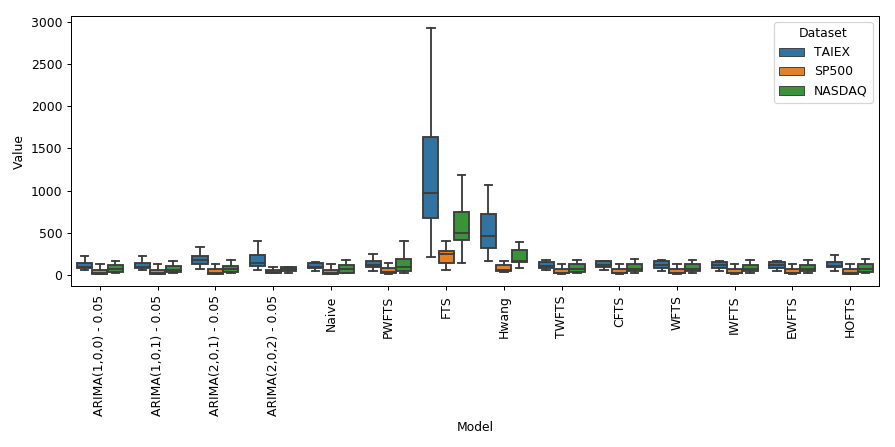

In [11]:
d1 = synthetic_dataframe("benchmarks.db","comparisons","rmse",False,False)
d2 = synthetic_dataframe("benchmarks.db","comparisons","rmse",False,True)
_filter = pd.concat([d1,d2])
final = filter_db_by("benchmarks.db",_filter,"comparisons","rmse")
fig = plt.figure(figsize=[10,5])
ax= sns.boxplot(x='Model', y='Value', hue='Dataset',  data=final, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


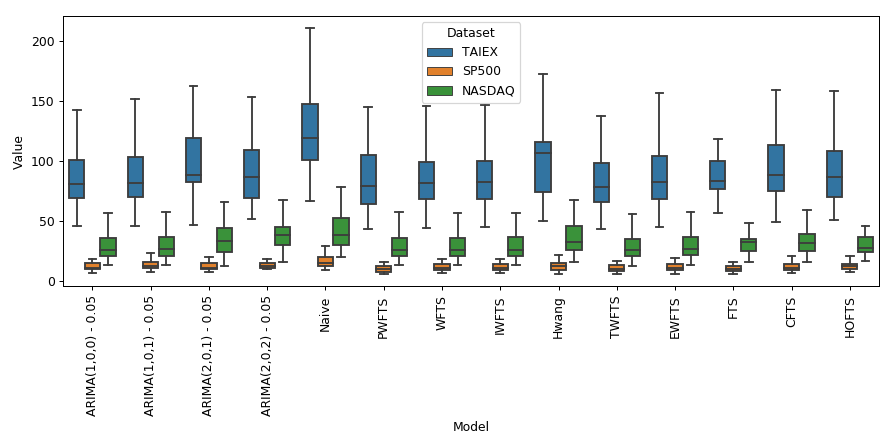

In [12]:
d1 = synthetic_dataframe("benchmarks.db","comparisons","rmse",True,False)
d2 = synthetic_dataframe("benchmarks.db","comparisons","rmse",True,True)
_filter = pd.concat([d1,d2])
final = filter_db_by("benchmarks.db",_filter,"comparisons","rmse")
fig = plt.figure(figsize=[10,5])
ax = sns.boxplot(x='Model', y='Value', hue='Dataset',  data=final, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


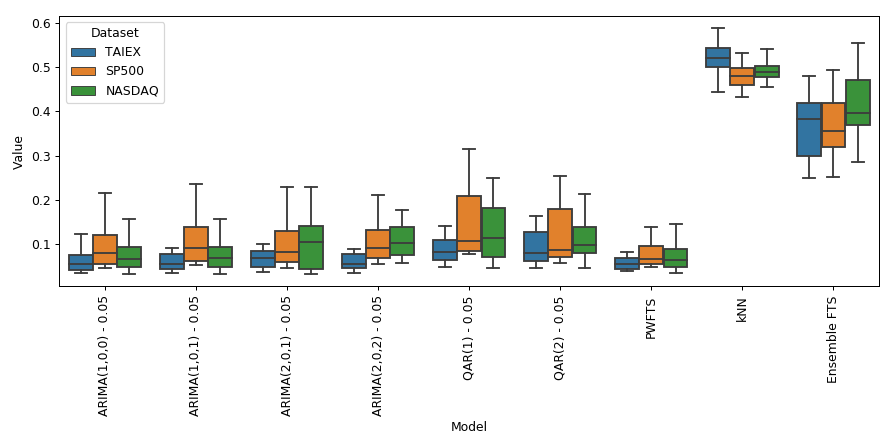

In [13]:
d1 = synthetic_dataframe("benchmarks.db","comparisons","crps",True,False)
d2 = synthetic_dataframe("benchmarks.db","comparisons","crps",True,True)
_filter = pd.concat([d1,d2])
final = filter_db_by("benchmarks.db",_filter,"comparisons","crps")
fig = plt.figure(figsize=[10,5])
ax = sns.boxplot(x='Model', y='Value', hue='Dataset',  data=final, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()

## Statistical Analysis

### Auxiliary functions

In [16]:
def to_stac(df, exclude=[], replace={}, csv=True):
    rows = []
    columns = []
    datasets = df.Dataset.unique()
    models = df.Model.unique()
    for model in models:
        test = np.any([model.rfind(k) != -1 for k in exclude]) if len(exclude) > 0 else False
        if not test:
            columns.append(model)

    for dataset in datasets:
        row = [dataset]
        for model in columns:
            avg = np.nanmin(df[(df.Dataset == dataset) & (df.Model == model)]["AVG"].values)
            row.append(avg)
        rows.append(row)
        
    for k in range(len(columns)):
        if columns[k] in replace:
            columns[k] = replace[columns[k]]
            
    columns.insert(0,"dataset")
    
    if csv:
        header = ""
        for k in range(len(columns)):
            if k > 0:
                header += ","
            header += columns[k]

        body = ""
        for k in range(len(rows)):
            row = ""
            for w in range(len(rows[k])):
                if w > 0:
                    row += ","
                row += str(rows[k][w])
            body += '\n{}'.format(row)

        return header + body
    else:
        ret = pd.DataFrame(rows,columns=columns)
        return ret
                

def test_mean_equality(tests):
    from stac.stac import nonparametric_tests as npt

    methods = tests.columns[1:]

    values = []
    for k in methods:
        values.append(tests[k].values)

    #f_value, p_value, rankings, pivots = npt.quade_test(*values)
    f_value, p_value, rankings, pivots = npt.friedman_aligned_ranks_test(*values)

    print("F-Value: {} \tp-Value: {}".format(f_value, p_value))

    post_hoc = {}
    rows = []
    for k in np.arange(0,len(methods)):
        rows.append([methods[k], rankings[k]])
        post_hoc[methods[k]] = pivots[k]

    return [pd.DataFrame(rows,columns=['METHOD','RANK']), post_hoc]


def post_hoc_tests(post_hoc, control_method):
    from stac.stac import nonparametric_tests as npt
    #comparisons, z_values, p_values, adj_p_values = npt.bonferroni_dunn_test(post_hoc,'PWFTS3')
    #comparisons, z_values, p_values, adj_p_values = npt.holm_test(post_hoc,'PWFTS3')
    comparisons, z_values, p_values, adj_p_values = npt.finner_test(post_hoc, control_method)

    rows = []
    for k in np.arange(len(comparisons)):
        rows.append([comparisons[k], z_values[k], p_values[k], adj_p_values[k]])

    return pd.DataFrame(rows,columns=['COMPARISON','Z-VALUE','P-VALUE','ADJUSTED P-VALUE'])
    
    

### Probabilistic Forecasting Benchmarks

In [17]:
d1 = synthetic_dataframe("benchmarks.db","comparisons","crps",True,False)
d2 = synthetic_dataframe("benchmarks.db","comparisons","crps",True,True)
_filter = pd.concat([d1,d2])

tests = to_stac(_filter, 
              exclude=['ARIMA(1,0,1)','ARIMA(2,0,1)','ARIMA(2,0,2)','QAR(1)'], 
              replace={'ARIMA(1,0,0) - 0.05': "ARIMA", "QAR(2) - 0.05":"QAR"}, 
                csv=False)

#print(tests)
tests

,dataset,PWFTS,Ensemble FTS,ARIMA,QAR,kNN
0,TAIEX,0.058174,0.365739,0.059609,0.094783,0.515870
1,NASDAQ,0.074813,0.416563,0.079062,0.115062,0.488187
2,SP500,0.080421,0.360000,0.094789,0.127737,0.477579


In [18]:
ranks,post_hoc = test_mean_equality(tests)
ranks

F-Value: 11.316931982633864 	p-Value: 0.023223818559276355


,METHOD,RANK
0,PWFTS,2.666667
1,Ensemble FTS,11.000000
2,ARIMA,4.333333
3,QAR,8.000000
4,kNN,14.000000


In [19]:
post_hoc_tests(post_hoc,'PWFTS')

,COMPARISON,Z-VALUE,P-VALUE,ADJUSTED P-VALUE
0,PWFTS vs kNN,3.103761,0.001911,0.007621
1,PWFTS vs Ensemble FTS,2.282177,0.022479,0.044452
2,PWFTS vs QAR,1.460593,0.144127,0.187396
3,PWFTS vs ARIMA,0.456435,0.648077,0.648077


### Interval Forecasting Benchmarks

In [20]:
d1 = synthetic_dataframe("benchmarks.db","comparisons","winkler05",True,False)
d2 = synthetic_dataframe("benchmarks.db","comparisons","winkler05",True,True)
_filter = pd.concat([d1,d2])

_filter

,Dataset,Model,Transformation,Order,Partitions,AVG,STD
12,SP500,IFTS,True,1,10,103.563684,29.783829
13,SP500,IFTS,True,2,10,104.617368,34.480334
14,SP500,IFTS,True,3,10,112.444737,64.575354
15,SP500,PWFTS,True,1,10,135.093684,100.033209
16,SP500,PWFTS,True,2,10,142.707368,106.614779
17,SP500,PWFTS,True,3,10,146.365263,113.298271
1,NASDAQ,IFTS,True,2,10,272.516250,92.054216
0,NASDAQ,IFTS,True,1,10,273.043750,87.403692
2,NASDAQ,IFTS,True,3,10,293.453750,144.769159
3,NASDAQ,PWFTS,True,1,10,304.370000,218.429780


In [21]:
tests = to_stac(_filter, 
              exclude=['- 0.25','ARIMA(2,','ARIMA(1,0,1)','QAR(1)'], 
              replace={'ARIMA(1,0,0) - 0.05': "ARIMA", "QAR(2) - 0.05":"QAR"}, 
                csv=False)

tests

,dataset,IFTS,PWFTS,ARIMA,QAR
0,SP500,103.563684,135.093684,97.563684,302.802632
1,NASDAQ,272.516250,304.370000,203.698125,824.185625
2,TAIEX,921.358261,751.046957,568.436087,2624.561739


In [22]:
ranks,post_hoc = test_mean_equality(tests)
ranks

F-Value: 6.945945945945946 	p-Value: 0.07364076147529353


,METHOD,RANK
0,IFTS,5.333333
1,PWFTS,5.666667
2,ARIMA,4.000000
3,QAR,11.000000


In [23]:
post_hoc_tests(post_hoc,'PWFTS')

,COMPARISON,Z-VALUE,P-VALUE,ADJUSTED P-VALUE
0,PWFTS vs QAR,1.811643,0.070041,0.195750
1,PWFTS vs ARIMA,0.566139,0.571300,0.719308
2,PWFTS vs IFTS,0.113228,0.909850,0.909850


### Point Forecasting Benchmarks

In [24]:
d1 = synthetic_dataframe("benchmarks.db","comparisons","rmse",True,False)
d2 = synthetic_dataframe("benchmarks.db","comparisons","rmse",True,True)
_filter = pd.concat([d1,d2])
_filter

,Dataset,Model,Transformation,Order,Partitions,AVG,STD
326,SP500,PWFTS,True,1,3,10.211579,3.501822
342,SP500,PWFTS,True,2,3,10.232105,3.530977
358,SP500,PWFTS,True,3,3,10.236842,3.554400
212,SP500,FTS,True,1,31,10.428947,3.580608
265,SP500,TWFTS,True,1,9,10.785263,3.817350
231,SP500,WFTS,True,1,5,11.446842,3.933307
279,SP500,EWFTS,True,1,5,11.460000,4.109399
247,SP500,IWFTS,True,1,5,11.508421,3.898699
216,SP500,CFTS,True,1,7,11.652105,3.558071
386,SP500,HOFTS,True,3,5,12.003684,3.240700


In [25]:
tests = to_stac(_filter, 
              exclude=['ARIMA(2,','ARIMA(1,0,1'], 
              replace={'ARIMA(1,0,0) - 0.05': "ARIMA"}, 
                csv=False)

tests

,dataset,PWFTS,FTS,TWFTS,WFTS,EWFTS,IWFTS,CFTS,HOFTS,Hwang,ARIMA,Naive
0,SP500,10.211579,10.428947,10.785263,11.446842,11.46000,11.508421,11.652105,12.003684,12.115789,11.797895,16.184211
1,NASDAQ,28.215625,31.949375,27.946875,28.716250,29.01625,28.700625,31.897500,30.475000,36.116875,28.530625,41.246250
2,TAIEX,83.721739,90.732174,85.350435,87.434783,88.70087,87.655652,95.086087,91.066522,105.541304,87.327391,127.240435


In [26]:
ranks,post_hoc = test_mean_equality(tests)
ranks

F-Value: 22.653279213843206 	p-Value: 0.012101323159714905


,METHOD,RANK
0,PWFTS,8.000000
1,FTS,17.333333
2,TWFTS,8.666667
3,WFTS,12.000000
4,EWFTS,13.333333
5,IWFTS,12.666667
6,CFTS,25.333333
7,HOFTS,17.666667
8,Hwang,29.000000
9,ARIMA,12.000000


In [27]:
post_hoc_tests(post_hoc,'PWFTS')

,COMPARISON,Z-VALUE,P-VALUE,ADJUSTED P-VALUE
0,PWFTS vs Naive,2.913182,0.003578,0.035206
1,PWFTS vs Hwang,2.659862,0.007817,0.038480
2,PWFTS vs CFTS,2.195442,0.028132,0.090734
3,PWFTS vs HOFTS,1.224381,0.220809,0.464067
4,PWFTS vs FTS,1.182161,0.237142,0.464067
5,PWFTS vs EWFTS,0.675521,0.499345,0.684332
6,PWFTS vs IWFTS,0.591080,0.554467,0.684935
7,PWFTS vs WFTS,0.506640,0.612407,0.694177
8,PWFTS vs ARIMA,0.506640,0.612407,0.694177
9,PWFTS vs TWFTS,0.084440,0.932707,0.932707
